# 06a - Differential binding energies

This notebook reproduces Fig. 6 from the manuscript and Figs. S21, S29, S30 from the Supporting Information. The data in this notebook shows how we obtained the integral and differential binding energy curves from the DFT data from structural relaxations.

In [1]:
import json
from basics import *
from plotting import *
from ase import Atoms
from scipy import stats
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from plotting import savefig

plt.style.use("paper")

## Visualizing the Monte Carlo approach

In [2]:
facets = [100, 111, 211, 331, 410, 711]
nads = np.arange(2, 24)
num_sites = {100: 16, 111: 16, 211: 24, 331: 24, 410: 24, 711: 16}

ORIGINAL = "#2F4259"
SAMPLED = "#C84260"

## Comparing previous relaxed energies and sampled ones

In [3]:
old = pd.read_json("../data/231003-COv-data.json.gz", compression="gzip").rename(columns={"num_adsorbates": "n"})
new = pd.read_csv("../data/05-mcmc-relax/231127-mcmc-relax.csv", index_col=0)

In [4]:
old = old[["facet", "n", "unrelax_id", "unrelax_binding_site", "relax_id", "relax_binding_site"]]

In [5]:
old["cov"] = [row["n"] / num_sites[row["facet"]] for _, row in old.iterrows()]
new["cov"] = [row["n"] / num_sites[row["facet"]] for _, row in new.iterrows()]

## Relaxed data

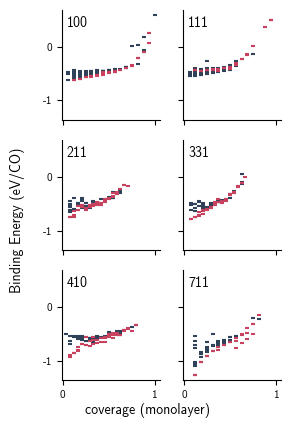

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(3, 4.5), sharex=True, sharey=True)

for ax, facet in zip(axs.ravel(), facets):
    j = facets.index(facet)
    subold = old.loc[old.facet == facet]
    subnew = new.loc[new.facet == facet]
    
    ax.scatter(
        subold["n"] / num_sites[facet],
        subold["relax_binding_site"],
        color=ORIGINAL,
        marker="_",
        s=12,
    )
    ax.scatter(
        subnew["n"] / num_sites[facet],
        subnew["relax_binding_site"],
        color=SAMPLED,
        marker="_",
        s=12,
    )

    ax.annotate(facet, (0.05, 0.95), xycoords="axes fraction", ha="left", va="top")

fig.supylabel("Binding Energy (eV/CO)", x=0.04, fontsize=10)
fig.supxlabel("coverage (monolayer)", y=0.06, fontsize=10)

fig.tight_layout()
savefig(fig, "04-relax-binding.pdf")
plt.show()

## Integral binding curve

In [12]:
full = pd.concat([
    old[["facet", "n", "cov", "unrelax_binding_site", "relax_binding_site"]],
    new[["facet", "n", "cov", "unrelax_binding_site", "relax_binding_site"]],
])

## Averaged integral binding curve

In [13]:
KTEMP = 25.852e-3
def boltzmann_avg(x, kT=KTEMP):
    xmin = x.min()
    wmin = np.exp(- xmin / kT)
    w = np.exp(-(x - xmin) / kT)
    return wmin * (w * x).sum() / (wmin * w).sum()

In [14]:
intbind = []
for (n, facet), grp in full.dropna().groupby(["n", "facet"]):
    x = (grp["relax_binding_site"]).values
    cov = grp["cov"].dropna().iloc[0]
    avg = boltzmann_avg(x, kT=KTEMP * 2)
#     avg = x.min()
    intbind.append({
        "facet": facet,
        "n": n,
        "avg": avg,
        "int": avg * cov,
        "cov": cov,
    })
    
intbind = pd.DataFrame(intbind)

In [15]:
def fn1(x, x0, A, B):
    C = - 3 * B * x0
    D = 3 * B * x0 ** 2 - A
    E = -B * x0 ** 3
    
    lin = -A * x
    cub = B * x ** 3 + C * x ** 2 + D * x + E
    
    y = np.where(x <= x0, lin, cub)
    
    return y

def fn2(x, x0, A, B):
    C = - A - 2 * B * x0
    D = B * x0 ** 2
    
    lin = -A * x
    quad = B * x ** 2 + C * x + D
    
    y = np.where(x <= x0, lin, quad)
    
    return y

# def fn3(x, x0, A, B, r):
#     C = - 3 * B * x0
#     D = 3 * B * x0 ** 2 - A
#     E = -B * x0 ** 3 + r
    
#     lin = -A * x + r
#     cub = B * x ** 3 + C * x ** 2 + D * x + E
    
#     y = np.where(x <= x0, lin, cub)
    
#     return y

In [16]:
fn = fn1
p0 = [0.5, 0.5, 2.0]

facet_params = {}
for facet in facets:
    grp = intbind.loc[intbind.facet == facet]
    params, _ = curve_fit(fn, grp["cov"].values, grp["int"].values, p0=p0, bounds=(0, np.inf))
    facet_params[facet] = params

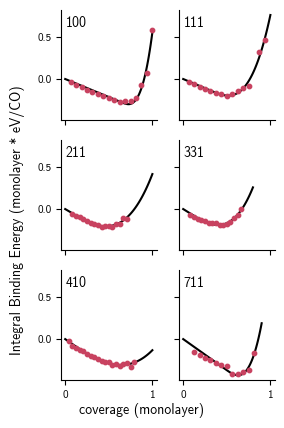

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(3, 4.5), sharex=True, sharey=True)

for ax, facet in zip(axs.ravel(), facets):
    j = facets.index(facet)
    grp = intbind.loc[intbind.facet == facet]
    params = facet_params[facet]
    
    ax.annotate(facet, (0.05, 0.95), xycoords="axes fraction", ha="left", va="top")
    
    ax.scatter(grp["cov"], grp["int"], c=SAMPLED, s=10)

    if facet == 331:
        xmax = 0.8
    elif facet == 711:
        xmax = 0.9
    else:
        xmax = 1.0
        
    _x = np.linspace(0, xmax, 100)
    _y = fn(_x, *params)
    ax.plot(_x, _y, "k-", zorder=-1)


fig.supylabel("Integral Binding Energy (monolayer * eV/CO)", x=0.06, fontsize=10)
fig.supxlabel("coverage (monolayer)", y=0.06, fontsize=10)

fig.tight_layout()
# savefig(fig, "05-relax-intbind.pdf")
plt.show()

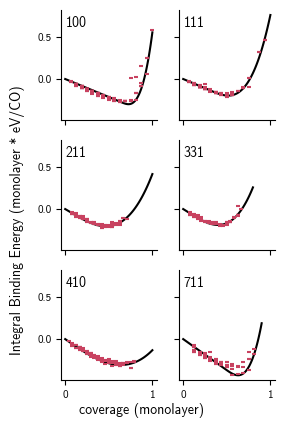

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(3, 4.5), sharex=True, sharey=True)

for ax, facet in zip(axs.ravel(), facets):
    j = facets.index(facet)
    grp = intbind.loc[intbind.facet == facet]
    params = facet_params[facet]
    
    ax.annotate(facet, (0.05, 0.95), xycoords="axes fraction", ha="left", va="top")
    
    subfull = full.loc[full.facet == facet]
    ax.scatter(
        subfull["cov"],
        subfull["relax_binding_site"] * subfull["cov"],
        c=SAMPLED,
        marker="_",
        s=10,
    )

    if facet == 331:
        xmax = 0.8
    elif facet == 711:
        xmax = 0.9
    else:
        xmax = 1.0
        
    _x = np.linspace(0, xmax, 100)
    _y = fn(_x, *params)
    ax.plot(_x, _y, "k-", zorder=-1)


fig.supylabel("Integral Binding Energy (monolayer * eV/CO)", x=0.06, fontsize=10)
fig.supxlabel("coverage (monolayer)", y=0.06, fontsize=10)

fig.tight_layout()
savefig(fig, "05-relax-intbind-data.pdf")
plt.show()

## Differential binding curve

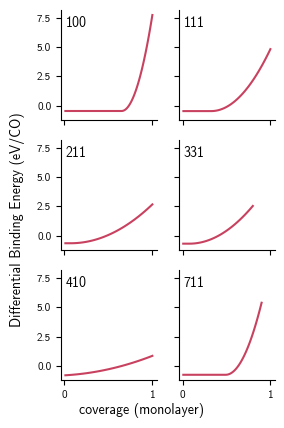

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(3, 4.5), sharex=True, sharey=True)

good_diffbind = {}

for ax, facet in zip(axs.ravel(), facets):
    j = facets.index(facet)
    grp = intbind.loc[intbind.facet == facet]
    
    ax.annotate(facet, (0.05, 0.95), xycoords="axes fraction", ha="left", va="top")
    
#     fn = fn1 if facet != 711 else fn2
#     p0 = [0.5, 1, 1] if facet != 711 else [0.5, 1, 1, 0.0]
    fn = fn1
    p0 = [0.3, 0.5, 2.0]
    params, _ = curve_fit(fn, grp["cov"].values, grp["int"].values, p0=p0)
    
    if facet == 331:
        xmax = 0.8
    elif facet == 711:
        xmax = 0.9
    else:
        xmax = 1.0
        
    _x = np.linspace(0, xmax, 100)
    _y = fn(_x, *params)
    dy = np.diff(_y) / np.diff(_x)
    
    good_diffbind[facet] = (_x[1:], dy, grp["cov"].max())
    
    ax.plot(_x[1:], dy, "-", color=SAMPLED)


fig.supylabel("Differential Binding Energy (eV/CO)", x=0.06, fontsize=10)
fig.supxlabel("coverage (monolayer)", y=0.06, fontsize=10)

fig.tight_layout()
savefig(fig, "05-relax-diffbind.pdf")
plt.show()

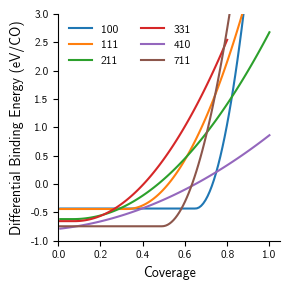

In [20]:
fig, ax = plt.subplots(figsize=(3, 3))

for facet in facets:
    j = facets.index(facet)
    grp = intbind.loc[intbind.facet == facet]
    
    fn = fn1 if facet != 711 else fn2
    p0 = [0.5, 1, 1] if facet != 711 else [0.5, 1, 1, 0.0]
    fn = fn1
    p0 = [0.3, 0.5, 2.0]
    params, _ = curve_fit(fn, grp["cov"].values, grp["int"].values, p0=p0)
    
    if facet == 331:
        xmax = 0.8
    elif facet == 711:
        xmax = 0.9
    else:
        xmax = 1.0
        
    _x = np.linspace(0, xmax, 100)
    _y = fn(_x, *params)
    
    dy = np.diff(_y) / np.diff(_x)
    
    ax.plot(_x[1:], dy, label=facet)

ax.set_ylabel("Differential Binding Energy (eV/CO)", x=0.06, fontsize=10)
ax.set_xlabel("Coverage", y=0.06, fontsize=10)
ax.set_ylim(-1, 3)
ax.set_xlim(0, 1.05)

ax.legend(frameon=False, ncols=2, fontsize="small", markerscale=0.3)
fig.tight_layout()
savefig(fig, "05-relax-diffbind2.pdf")
plt.show()

## Desorption energies

In [21]:
kJ_mol = 0.01036410 ## eV

In [22]:
for facet, params in facet_params.items():
    print(f"{facet}: {params[1] * 1000:.0f} meV/CO")

100: 432 meV/CO
111: 440 meV/CO
211: 619 meV/CO
331: 655 meV/CO
410: 728 meV/CO
711: 745 meV/CO


In [23]:
expt = pd.DataFrame([
    {"facet": 100, "energy": 51.1, "error": 1.4},
    {"facet": 111, "energy": 47.3, "error": 1.4},
    {"facet": 211, "energy": 58.4, "error": 1.4},
    {"facet": 410, "energy": 70, "error": 3},
])

expt["energy"] = expt["energy"] * kJ_mol * 1000
expt["error"] = expt["error"] * kJ_mol * 1000

In [24]:
expt

,facet,energy,error
0,100,529.60551,14.50974
1,111,490.22193,14.50974
2,211,605.26344,14.50974
3,410,725.48700,31.09230


In [25]:
full = pd.concat([
    old[["facet", "n", "cov", "unrelax_binding_site", "relax_binding_site"]],
#     new[["facet", "n", "cov", "unrelax_binding_site", "relax_binding_site"]],
])

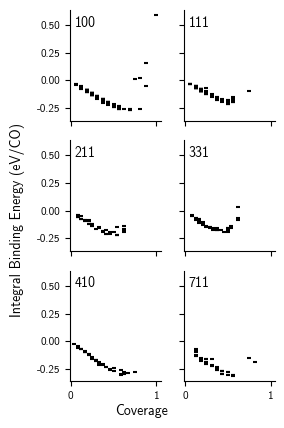

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(3, 4.5), sharex=True, sharey=True)

for ax, facet in zip(axs.ravel(), facets):
    j = facets.index(facet)
    grp = full.loc[full.facet == facet]
    
    ax.scatter(
        grp["cov"],
        grp["relax_binding_site"] * grp["cov"],
        color="k",
        marker="_",
        s=10,
    )

    ax.annotate(facet, (0.05, 0.95), xycoords="axes fraction", ha="left", va="top")

fig.supylabel("Integral Binding Energy (eV/CO)", x=0.06, fontsize=10)
fig.supxlabel("Coverage", y=0.06, fontsize=10)

fig.tight_layout()
# savefig(fig, "01-dset-distributions.pdf")
plt.show()

## Averaged integral binding curve

In [27]:
intbind = []
for (n, facet), grp in full.dropna().groupby(["n", "facet"]):
    x = (grp["relax_binding_site"]).values
    cov = grp["cov"].dropna().iloc[0]
    
    avg = boltzmann_avg(x, kT=25e-3 * 2)
#     avg = x.min()
    intbind.append({
        "facet": facet,
        "n": n,
        "avg": avg,
        "int": avg * cov,
        "cov": cov,
    })
    
intbind = pd.DataFrame(intbind)

[0.53248399 0.42714    9.68930948]
[0.20625438 0.46722491 1.57199884]
[0.09955448 0.5641299  1.1841814 ]
[0.12431003 0.57801931 2.23708443]
[0.15674158 0.60804354 0.84690738]
[-0.18027305  1.03385205  0.70737642]


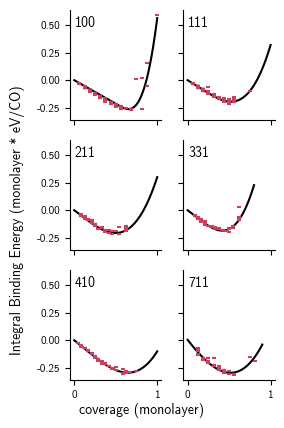

In [28]:
fig, axs = plt.subplots(3, 2, figsize=(3, 4.5), sharex=True, sharey=True)

for ax, facet in zip(axs.ravel(), facets):
    j = facets.index(facet)
    grp = intbind.loc[intbind.facet == facet]
    
    ax.annotate(facet, (0.05, 0.95), xycoords="axes fraction", ha="left", va="top")
    
#     ax.scatter(grp["cov"], grp["int"], c=SAMPLED, s=10)
    subfull = full.loc[full.facet == facet]
    ax.scatter(
        subfull["cov"],
        subfull["relax_binding_site"] * subfull["cov"],
        c=SAMPLED,
        marker="_",
        s=10,
    )
    
#     fn = fn1 if facet != 711 else fn2
#     p0 = [0.5, 1, 1] if facet != 711 else [0.5, 1, 1, 0.0]
    fn = fn1
    p0 = [0.3, 0.5, 2.0]
    params, _ = curve_fit(fn, grp["cov"].values, grp["int"].values, p0=p0)
    print(params)
    
    if facet == 331:
        xmax = 0.8
    elif facet == 711:
        xmax = 0.9
    else:
        xmax = 1.0
        
    _x = np.linspace(0, xmax, 100)
    _y = fn(_x, *params)
    ax.plot(_x, _y, "k-", zorder=-1)


fig.supylabel("Integral Binding Energy (monolayer * eV/CO)", x=0.06, fontsize=10)
fig.supxlabel("coverage (monolayer)", y=0.06, fontsize=10)

fig.tight_layout()
# savefig(fig, "05-relax-intbind-data.pdf")
plt.show()

## Differential binding curve

TypeError: fn2() takes 4 positional arguments but 5 were given

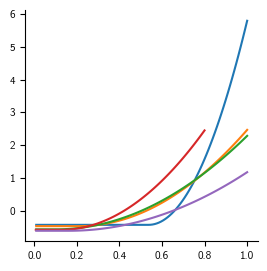

In [29]:
fig, ax = plt.subplots(figsize=(3, 3))

orig_diffbind = {}

for facet in facets:
    j = facets.index(facet)
    grp = intbind.loc[intbind.facet == facet]
    
    fn = fn1 if facet != 711 else fn2
    p0 = [0.5, 1, 1] if facet != 711 else [0.5, 1, 1, 0.0]
    params, _ = curve_fit(fn, grp["cov"].values, grp["int"].values, p0=p0)
    
    if facet == 331:
        xmax = 0.8
    elif facet == 711:
        xmax = 0.9
    else:
        xmax = 1.0
        
    _x = np.linspace(0, xmax, 100)
    _y = fn(_x, *params)
    
    dy = np.diff(_y) / np.diff(_x)
    orig_diffbind[facet] = (_x[1:], dy, grp["cov"].max())
    
    ax.plot(_x[1:], dy, label=facet)


ax.set_ylabel("Differential Binding Energy (eV/CO)", x=0.06, fontsize=10)
ax.set_xlabel("Coverage", y=0.06, fontsize=10)
ax.set_ylim(-1, 3)

ax.legend(frameon=False, ncols=2, fontsize="small", markerscale=0.3)
fig.tight_layout()
# savefig(fig, "05-relax-diffbind2.pdf")
plt.show()

## Original vs sampled

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(3, 4.5), sharex=True, sharey=True)

for ax, facet in zip(axs.ravel(), facets):
    x1, y1, m1 = orig_diffbind[facet]
    x2, y2, m2 = good_diffbind[facet]
    
#     i1 = (x1 <= m1)
#     x1, y1 = x1[i1], y1[i1]
#     i2 = (x2 <= m2)
#     x2, y2 = x2[i2], y2[i2]
    
    ax.plot(x1, y1, "-", color=ORIGINAL)
    ax.plot(x2, y2, "-", color=SAMPLED)
    
    ax.annotate(facet, (0.05, 0.95), xycoords="axes fraction", ha="left", va="top")

for ax in axs.ravel():
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 3)

fig.supylabel("Differential Binding Energy (eV/CO)", x=0.06, fontsize=10)
fig.supxlabel("coverage (monolayer)", y=0.06, fontsize=10)

fig.tight_layout()
# savefig(fig, "05-relax-diffbind.pdf")
plt.show()